In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import jax.scipy as jsp 
import random
import os
import torch
plt.rc("figure", figsize=[6,6], dpi=150, facecolor='w')
import numpy as np
def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return np.random.default_rng(seed)
rng = seed_torch()

/Users/phinate/code/flow-interpolation/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@jax.vmap
def TT(s):
    theta = jnp.arctan(s[1]/s[0])
    r = ((s[0]**2 + s[1]**2)**.5)/2
    T = jnp.array(
            [[jnp.cos(theta), jnp.sin(theta)],[-jnp.sin(theta), jnp.cos(theta)]]
        ) @ jnp.array([[1/r,0],[0,1]])
    return T @ T.T

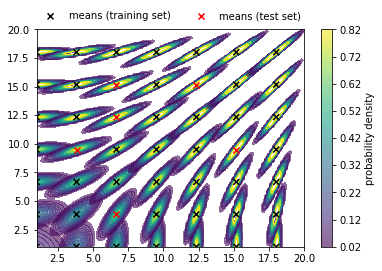

In [3]:

def xy_pairs(nx, ny, start, stop):
    size = nx, ny
    x_grid = jnp.linspace(start, stop, nx)
    y_grid = jnp.linspace(start, stop, ny)
    xx, yy = jnp.meshgrid(x_grid, y_grid)
    return jnp.hstack((xx.reshape(-1,1), yy.reshape(-1,1))), size, xx, yy

val = 15
xy_pairs_eval, grid_size, xx, yy = xy_pairs(100,100, 1, 20)
num_means = 7
means, g, xx2, yy2 = xy_pairs(num_means,num_means, 1, 18)

covs = TT(means)

def gaussian_2d_pdf(eval_points, mean, cov):
    return jsp.stats.multivariate_normal.pdf(eval_points, mean=mean, cov=cov)

vmapped_pdf = jax.vmap(gaussian_2d_pdf, in_axes=(None, 0, 0))

# covs = jnp.array([[[1, 0],[3,3]] for _ in means])
pdfs = vmapped_pdf(xy_pairs_eval, means, covs).reshape(len(means), *grid_size) 

fig, ax = plt.subplots()

step = 0.02
m = jnp.amax(pdfs[int(len(pdfs) / 2 - num_means/4)])
levels = jnp.arange(0.0, m, step) + step
for i,pdf in enumerate(pdfs):
    a = ax.contourf(xx, yy, pdf,  alpha=0.6, cmap='viridis',levels=levels)

inner_means = means.reshape(num_means, num_means, 2)[1:-1, 1:-1, :].reshape(-1, 2)
test_idxs = rng.choice(len(inner_means), size=int(len(inner_means)/4), replace=False)
test = inner_means[test_idxs].tolist()
# test = [[-5.5714287757873535, 1.8571434020996094],
#  [1.8571434020996094, -9.285714149475098],
#  [-1.8571422100067139, -5.5714287757873535],
#  [-1.8571422100067139, 5.57142972946167],
#  [1.8571434020996094, 1.8571434020996094],
#  [5.57142972946167, -1.8571422100067139],
#  [-5.5714287757873535, -5.5714287757873535],
#  [-9.285714149475098, 5.57142972946167],
#  [5.57142972946167, 9.285715103149414],
#  [9.285715103149414, 1.8571434020996094],
#  [-9.285714149475098, -1.8571422100067139]]

ax.scatter(xx2, yy2, marker='x', c=['None' if x in test else 'k' for x in means.tolist()], label ="means (training set)")
ax.scatter(np.array(test)[:,0], np.array(test)[:,1], marker='x', c='r', label ="means (test set)")

plt.colorbar(a, ax=ax, label="probability density")
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2, frameon=False)
# ax.legend(loc="upper center", fancybox=True,);

In [4]:
len(means)

49

In [5]:
from jax.random import multivariate_normal, PRNGKey

train_mask = jnp.array([x not in test for x in means.tolist()])
train_context = means[train_mask]  # making this a variable for use later

@jax.vmap
def samples(mean, cov):
    return multivariate_normal(PRNGKey(0), mean, cov, shape=(10000,))

train_samples = samples(train_context, covs[train_mask])
assert train_samples.shape[0] == len(means) - len(test)

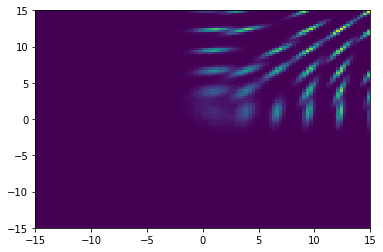

In [6]:
fig, ax = plt.subplots()

bins = np.linspace(-val, val, 100), np.linspace(-val, val, 100)


def plot(ax, s, i):
    x, y = s[:,0], s[:,1]
    ax.hist2d(x,y, density=True, bins=bins)
    ax.set_xlim((-val,val))
    ax.set_ylim((-val,val))

plot(ax, jnp.concatenate(train_samples), 0)
# ax.scatter(xx2, yy2, marker='x', c='r', label ="distribution means")

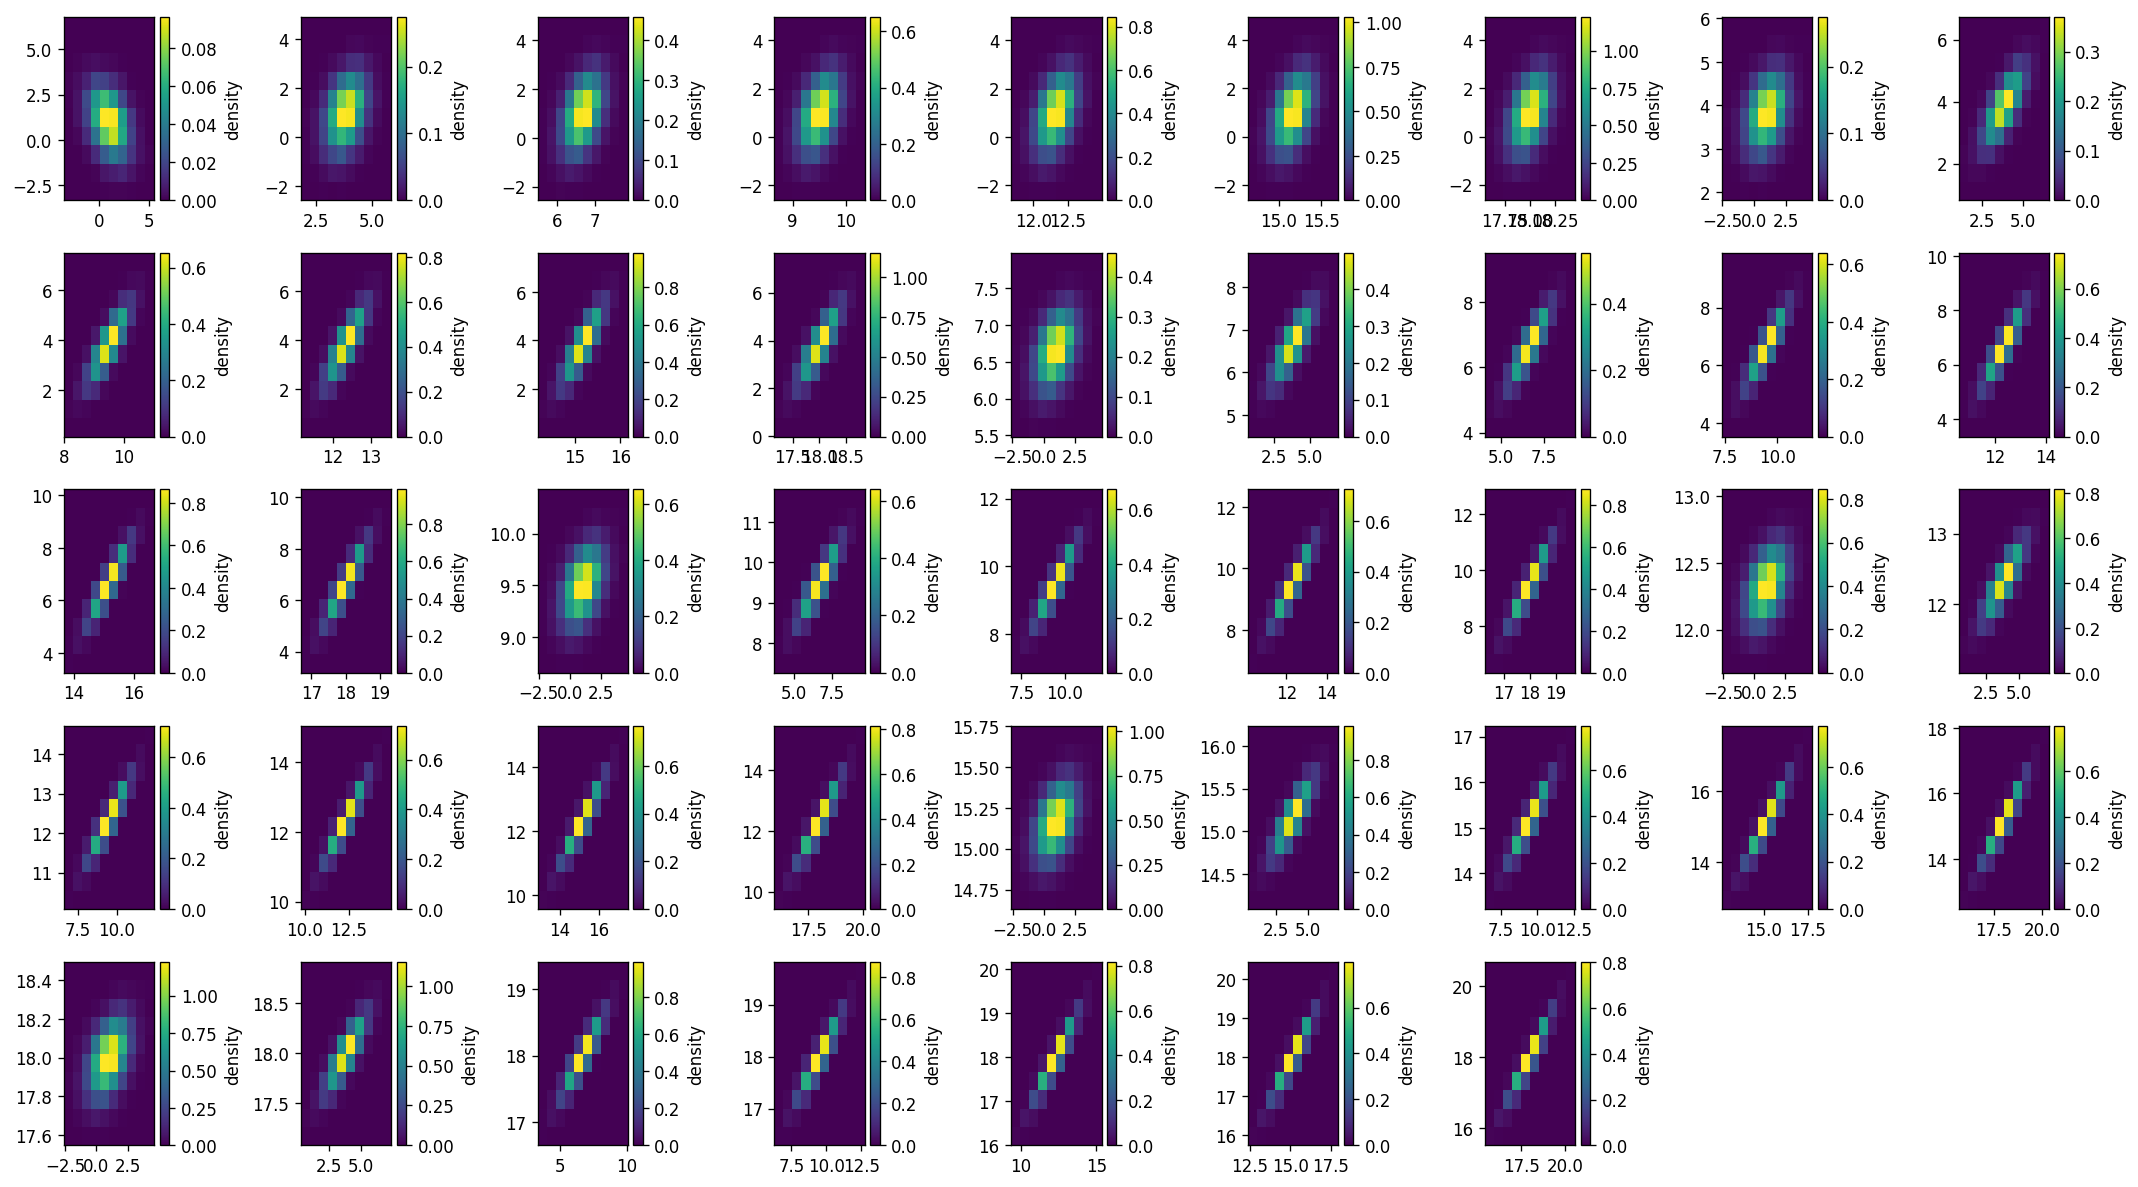

In [7]:
from plothelp import autogrid
from flow_interp import train, sample

train_data_hists, train_x_bins, train_y_bins = sample.make_data_hists2d(train_samples)

def hist_plot(ax, stuff, i):
    hist, *bins = stuff
    XX, YY = np.meshgrid(bins[0], bins[1])
    a = ax.pcolormesh(XX, YY, (hist.T), shading='flat',cmap='viridis')#, norm=colors.LogNorm())
    plt.colorbar(a, ax=ax, label='density')

autogrid(
    list(zip(train_data_hists, train_x_bins, train_y_bins)),
    hist_plot,
);

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

train_context_array = np.concatenate([[train_context[i].tolist()]*len(train_samples[i]) for i in range(len(train_samples))])

train_concat = np.concatenate(train_samples)


train_and_valid = np.hstack((train_concat, train_context_array))
rng.shuffle(train_and_valid)

# do a second validation split that uses data from the context points in the training set
train_all, valid_from_train = train_test_split(train_and_valid, test_size=0.2)
feature_scaler = StandardScaler().fit(train_all[:,:2])
context_scaler = StandardScaler().fit(train_all[:,2:])

In [9]:
def batches(train, batch_size, rng):
    num_train = train.shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)

    # batching mechanism
    def data_stream():
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size : (i + 1) * batch_size]
                yield train[batch_idx][:, :2], train[batch_idx][:, 2:]  # features, context

    return data_stream()

batch_iter = batches(train_all, 4000, rng)

In [10]:
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation




optimiser=optim.Adam
optimiser_pars=dict(lr=1e-3)

def make_flow(num_layers=6, hidden_features=4):
    base_dist = ConditionalDiagonalNormal(shape=[2], context_encoder=nn.Linear(2, 4))

    transforms = []
    for _ in range(num_layers):
        transforms.append(ReversePermutation(features=2))
        transforms.append(
            MaskedAffineAutoregressiveTransform(
                features=2, hidden_features=hidden_features, context_features=2
            )
        )
    transform = CompositeTransform(transforms)

    return Flow(transform, base_dist)

flow = make_flow()
opt = optimiser(flow.parameters(), **optimiser_pars)

In [11]:
test_samples = samples(jnp.array(test), covs[~train_mask])
assert test_samples.shape[0] == len(test)
test_data_hists, test_x_bins, test_y_bins = sample.make_data_hists2d(test_samples)
test_mask = jnp.array([x in test for x in means.tolist()])
test_covs = covs[test_mask]

In [12]:
from flow_interp import train
test_context_array = np.concatenate([[test[i]]*len(test_samples[i]) for i in range(len(test))])
valid_from_test = np.hstack((np.concatenate(test_samples), test_context_array))
valid = np.concatenate(
    (valid_from_train[:,:2], valid_from_test[:, :2])
    ), np.concatenate(
        (valid_from_train[:,2:], valid_from_test[:, 2:])
    )

result, metric, iteration, losses = train.train_loop(
    6000, 
    flow, 
    opt, 
    batch_iter, 
    valid_set = valid, 
    feature_scaler=feature_scaler, 
    context_scaler=context_scaler,
    print_every = 500
)

iteration 0:
train loss = 9.307220458984375
valid loss = 8.88502025604248
iteration 499:
train loss = -1.941065788269043
valid loss = -1.6739941835403442
iteration 999:
train loss = -2.406729221343994
valid loss = -1.8163257837295532
iteration 1499:
train loss = -2.495591640472412
valid loss = -1.6299830675125122
iteration 1999:
train loss = -2.5298900604248047
valid loss = -1.5651005506515503
iteration 2499:
train loss = -2.569014072418213
valid loss = -1.5386645793914795
iteration 2999:
train loss = -2.5325536727905273
valid loss = -1.559053897857666


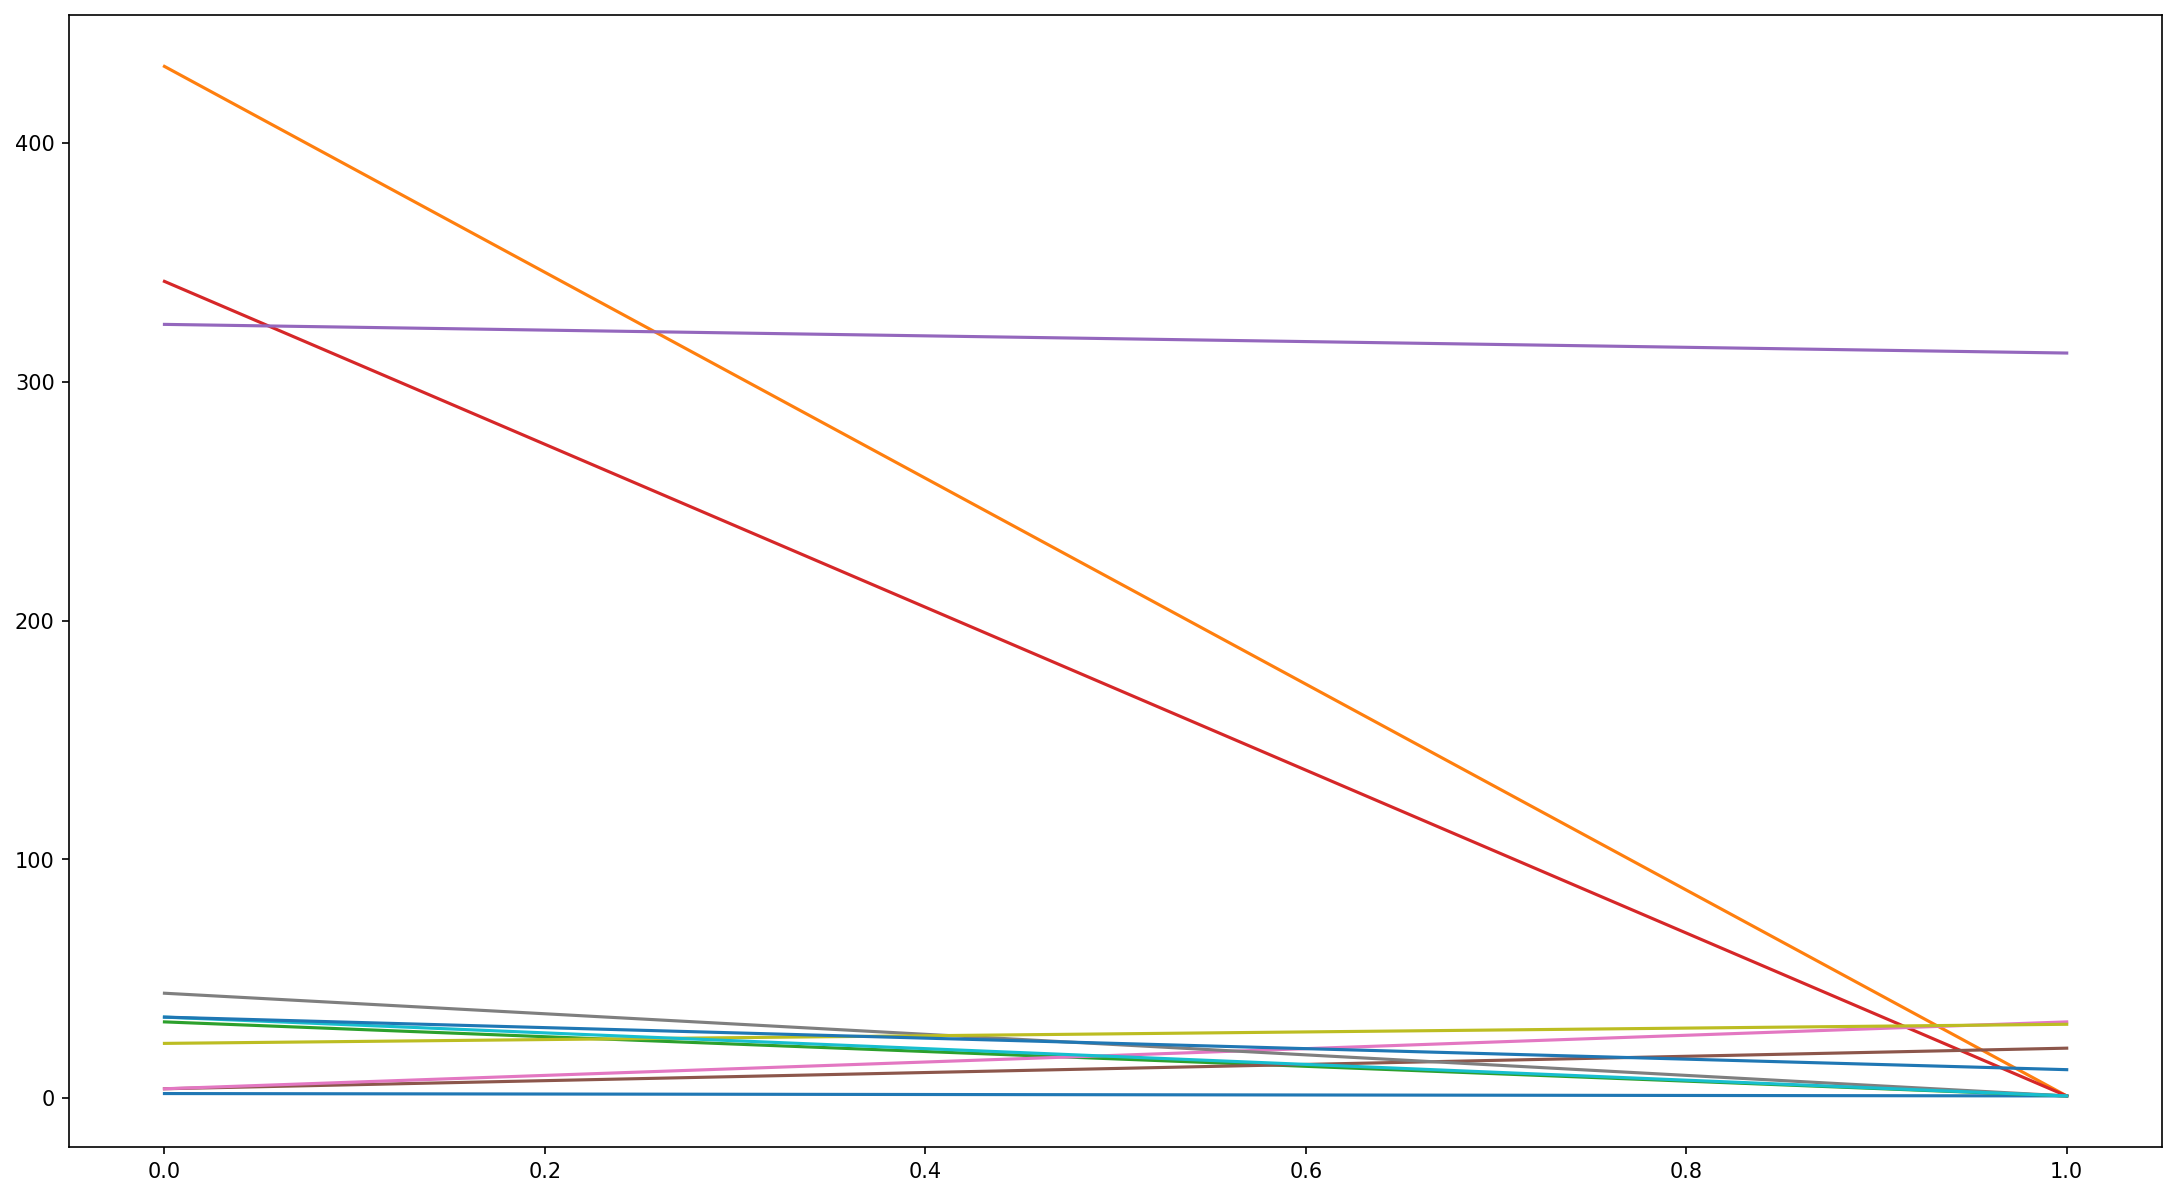

In [ ]:
plt.plot(losses[0], label='train')
plt.plot(losses[1], label='valid')
plt.vlines(iteration, 0, max(losses))
plt.legend()

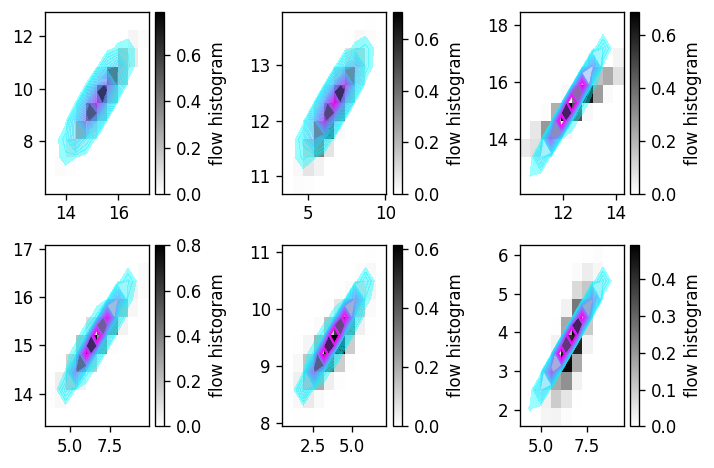

In [43]:
flow.load_state_dict(result)
flow_hists, _ = sample.hist2d_from_flows_with_error([flow], test_x_bins, test_y_bins, feature_scaler, context_scaler=context_scaler, context=test, num_samples=10000, density=True)
def hist_plot_flow(ax, stuff, i):
    hist, *bins = stuff
    XX, YY = np.meshgrid(bins[0], bins[1])
    pairs = jnp.hstack((XX.reshape(-1,1), YY.reshape(-1,1)))
    pdf = gaussian_2d_pdf(pairs, jnp.array(test[i]), test_covs[i]).reshape(XX.shape)
    a = ax.pcolormesh(XX, YY, (hist.T), shading='flat',cmap='binary')#, norm=colors.LogNorm())
    ax.contourf(XX, YY, pdf, levels=levels, alpha=0.4, cmap='cool')
    plt.colorbar(a, ax=ax, label='flow histogram')
    

autogrid(
    list(zip(flow_hists, test_x_bins, test_y_bins)),
    hist_plot_flow,
);

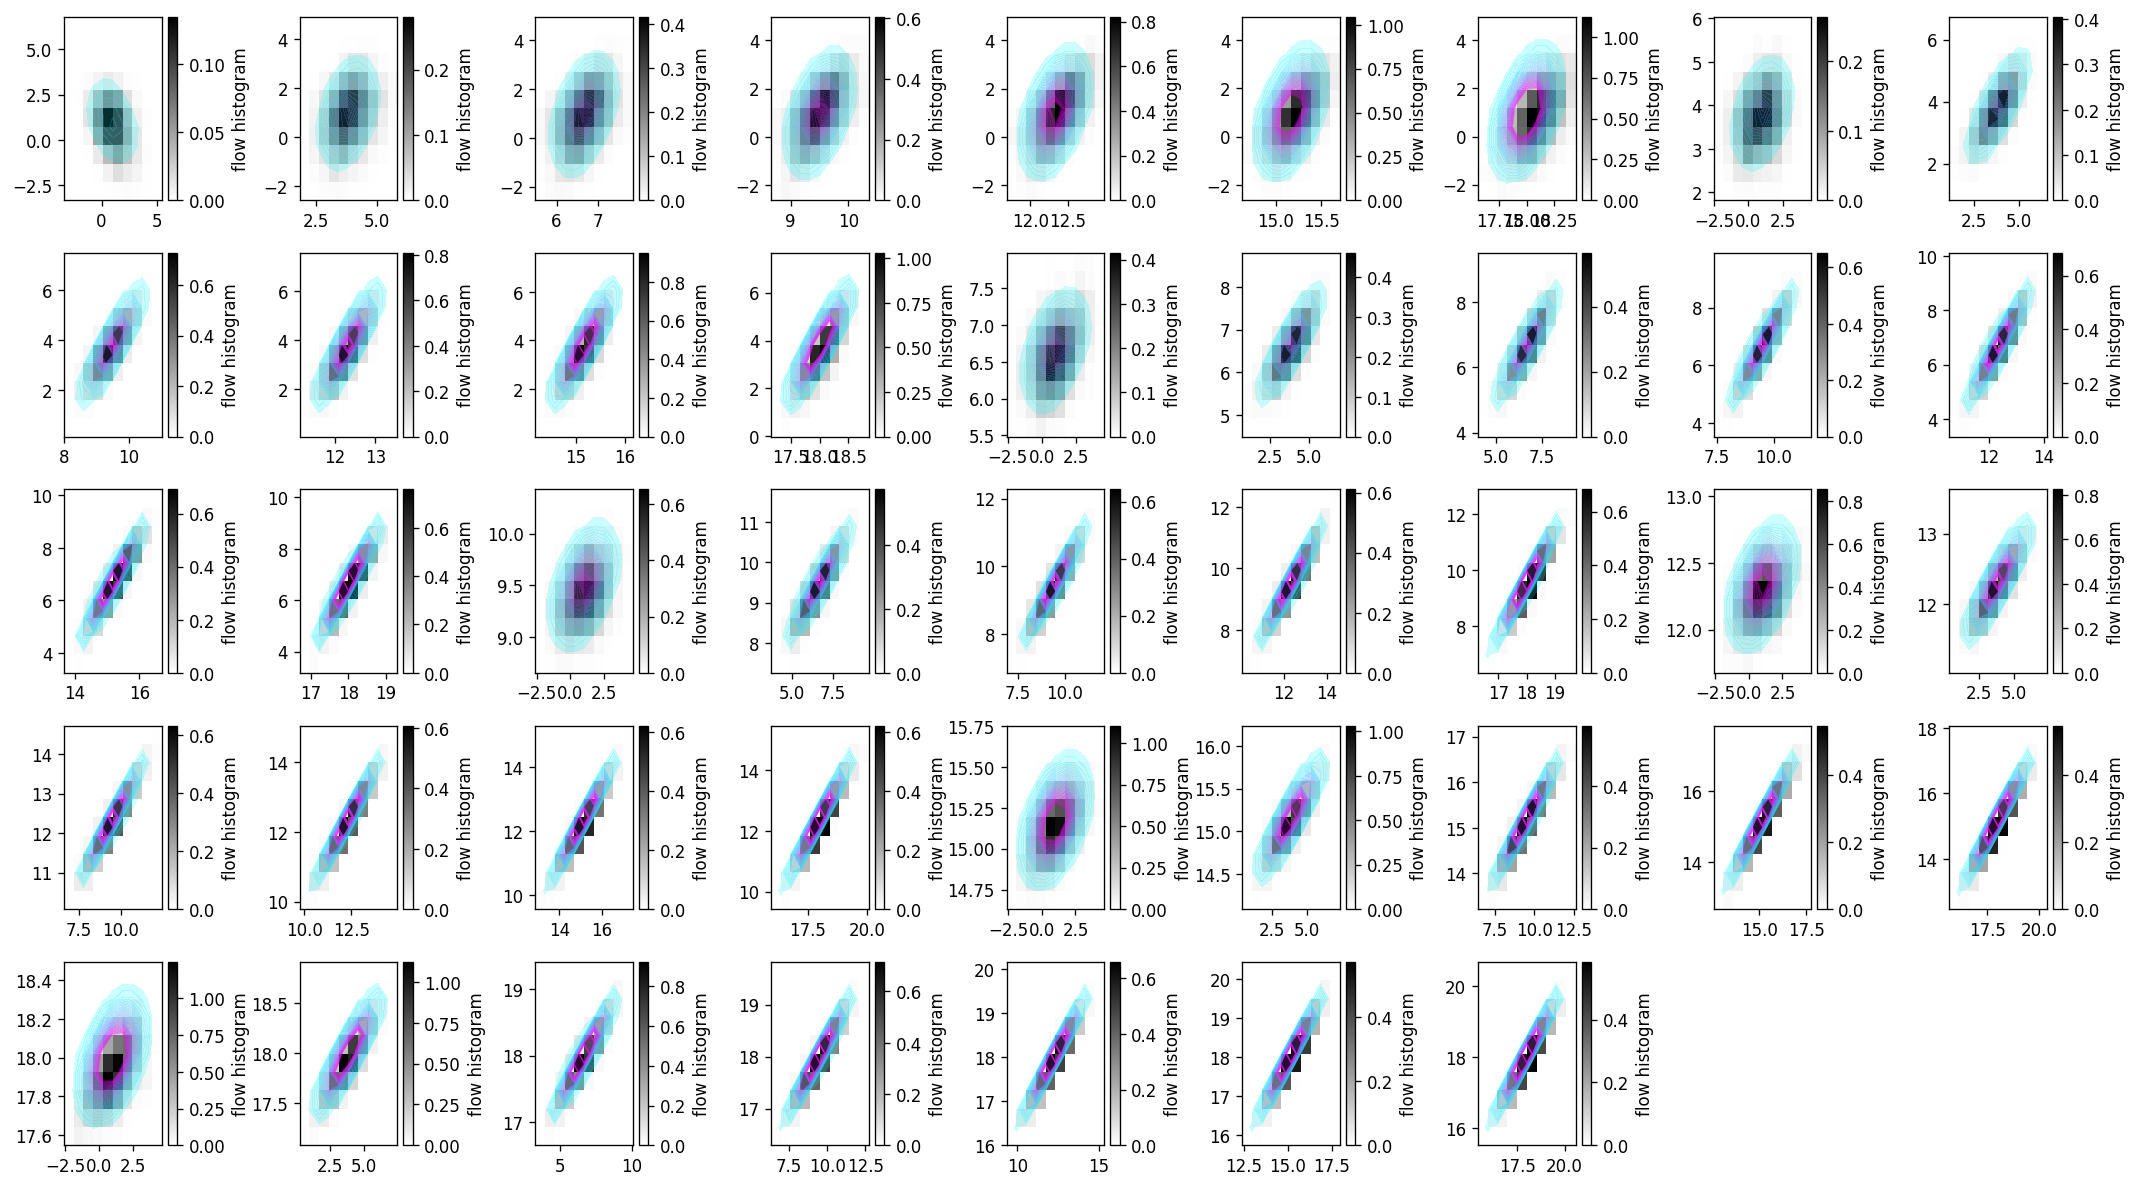

In [44]:
flow.load_state_dict(result)
flow_hists, _ = sample.hist2d_from_flows_with_error([flow], train_x_bins, train_y_bins, feature_scaler, context_scaler=context_scaler, context=train_context, num_samples=10000, density=True)
def hist_plot_flow(ax, stuff, i):
    hist, *bins = stuff
    XX, YY = np.meshgrid(bins[0], bins[1])
    pairs = jnp.hstack((XX.reshape(-1,1), YY.reshape(-1,1)))
    pdf = gaussian_2d_pdf(pairs, jnp.array(train_context[i]), covs[train_mask][i]).reshape(XX.shape)
    a = ax.pcolormesh(XX, YY, (hist.T), shading='flat',cmap='binary')#, norm=colors.LogNorm())
    ax.contourf(XX, YY, pdf, levels=levels, alpha=0.2, cmap='cool')
    plt.colorbar(a, ax=ax, label='flow histogram')
    

autogrid(
    list(zip(flow_hists, train_x_bins, train_y_bins)),
    hist_plot_flow,
);

In [15]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)

lrs = [1e-2, 5e-2, 1e-3]
valid_errors = {}

for lr in lrs:
    valid_error = 0
    for i,(train_idxs, valid_idxs) in enumerate(kf.split(train_context.tolist())):
        print(f'fold {i+1}')
        train_points = train_context[train_idxs].tolist()
        valid_points = train_context[valid_idxs].tolist()
        train_fold, valid_fold = np.concatenate(train_samples[train_idxs]), np.concatenate(train_samples[valid_idxs])
        train_fold_context_array = np.concatenate([[train_context[i].tolist()]*len(train_samples[i]) for i in train_idxs])
        assert train_fold.shape == train_fold_context_array.shape
        train_fold_all = np.hstack((train_fold, train_fold_context_array))
        fold_batch_iter = batches(train_fold_all, batch_size=4000, rng=rng)
        flow = make_flow()
        opt = optimiser(flow.parameters(), lr=lr)    
        _ = train.train_loop(6000, flow, opt, fold_batch_iter, feature_scaler=feature_scaler, context_scaler=context_scaler)
        valid_hists, valid_x_bins, valid_y_bins = sample.make_data_hists2d(train_samples[valid_idxs])
        flow_valid_hists, _ = sample.hist2d_from_flows_with_error([flow], valid_x_bins, valid_y_bins, feature_scaler, context_scaler=context_scaler, context=valid_points, num_samples=10000, density=True)
        metric = np.sum((valid_hists-flow_valid_hists)**2)
        valid_error += metric
    valid_errors[str(lr)] = valid_error


fold 1
iteration 0:
train loss = 7.9567179679870605
iteration 1000:
train loss = -2.6999852657318115
iteration 2000:
train loss = -2.7371997833251953
iteration 3000:
train loss = -2.5210530757904053
iteration 4000:
train loss = -2.8442599773406982
iteration 5000:
train loss = -2.879882335662842
fold 2
iteration 0:
train loss = 6.660597801208496
iteration 1000:
train loss = -2.5468084812164307
iteration 2000:
train loss = -2.8057429790496826
iteration 3000:
train loss = -2.816786527633667
iteration 4000:
train loss = -3.0173661708831787
iteration 5000:
train loss = -2.9814369678497314
fold 3
iteration 0:
train loss = 7.972988128662109
iteration 1000:
train loss = -2.805800199508667
iteration 2000:
train loss = -2.9044902324676514
iteration 3000:
train loss = -3.0762429237365723
iteration 4000:
train loss = -3.0440967082977295
iteration 5000:
train loss = -2.978025436401367
fold 4
iteration 0:
train loss = 7.55742073059082
iteration 1000:
train loss = -2.8773081302642822
iteration 2000:


/Users/phinate/code/flow-interpolation/venv/lib/python3.9/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s


fold 6
iteration 0:
train loss = 6.017651557922363
iteration 1000:
train loss = -1.632562518119812
iteration 2000:
train loss = -2.679440498352051
iteration 3000:
train loss = -2.794825553894043
iteration 4000:
train loss = -2.447265863418579
iteration 5000:
train loss = -2.708834648132324
fold 7
iteration 0:
train loss = 6.147671699523926
iteration 1000:
train loss = -2.2204158306121826
iteration 2000:
train loss = -0.9720146656036377
iteration 3000:
train loss = -2.5012760162353516
iteration 4000:
train loss = -2.382936954498291
iteration 5000:
train loss = -2.2606875896453857
fold 8
iteration 0:
train loss = 8.320338249206543
iteration 1000:
train loss = -1.9563896656036377
iteration 2000:
train loss = -2.2079286575317383
iteration 3000:
train loss = -2.6528804302215576
iteration 4000:
train loss = -2.0533978939056396
iteration 5000:
train loss = -2.799391746520996
fold 9
iteration 0:
train loss = 8.297635078430176
iteration 1000:
train loss = -2.27325701713562
iteration 2000:
train

In [19]:
lr = 1e-2  # best lr from previous step
num_iters = [5500, 6000, 6500, 7000]
valid_errors = {}

for num_iter in num_iters:
    valid_error = 0
    for i,(train_idxs, valid_idxs) in enumerate(kf.split(train_context.tolist())):
        print(f'fold {i+1}')
        train_points = train_context[train_idxs].tolist()
        valid_points = train_context[valid_idxs].tolist()
        train_fold, valid_fold = np.concatenate(train_samples[train_idxs]), np.concatenate(train_samples[valid_idxs])
        train_fold_context_array = np.concatenate([[train_context[i].tolist()]*len(train_samples[i]) for i in train_idxs])
        assert train_fold.shape == train_fold_context_array.shape
        train_fold_all = np.hstack((train_fold, train_fold_context_array))
        fold_batch_iter = batches(train_fold_all, batch_size=4000, rng=rng)
        flow = make_flow()
        opt = optimiser(flow.parameters(), lr=lr)    
        _ = train.train_loop(num_iter, flow, opt, fold_batch_iter, feature_scaler=feature_scaler, context_scaler=context_scaler)
        valid_hists, valid_x_bins, valid_y_bins = sample.make_data_hists2d(train_samples[valid_idxs])
        flow_valid_hists, _ = sample.hist2d_from_flows_with_error([flow], valid_x_bins, valid_y_bins, feature_scaler, context_scaler=context_scaler, context=valid_points, num_samples=10000, density=True)
        metric = np.sum((valid_hists-flow_valid_hists)**2)
        valid_error += metric
    valid_errors[str(num_iter)] = valid_error

fold 1
iteration 0:
train loss = 9.008451461791992
iteration 1000:
train loss = -2.7391791343688965
iteration 2000:
train loss = -2.8751626014709473
iteration 3000:
train loss = -3.0228261947631836
iteration 4000:
train loss = -3.001758575439453
iteration 5000:
train loss = -2.99308705329895
fold 2
iteration 0:
train loss = 8.523514747619629
iteration 1000:
train loss = -2.6200249195098877
iteration 2000:
train loss = -2.57924747467041
iteration 3000:
train loss = -2.9827499389648438
iteration 4000:
train loss = -3.1038661003112793
iteration 5000:
train loss = -3.0025458335876465
fold 3
iteration 0:
train loss = 11.712506294250488
iteration 1000:
train loss = -2.5549232959747314
iteration 2000:
train loss = -2.7090444564819336
iteration 3000:
train loss = -2.9558520317077637
iteration 4000:
train loss = -3.1312077045440674
iteration 5000:
train loss = -2.9403679370880127
fold 4
iteration 0:
train loss = 9.189620018005371
iteration 1000:
train loss = -2.5106234550476074
iteration 2000:


In [20]:
valid_error_res = {'5500': 41.45121081982253,
 '6000': 42.40899898187116,
 '6500': 40.91227636062254,
 '7000': 44.72141666924373}

num_iter = 6500

{'5500': 41.45121081982253,
 '6000': 42.40899898187116,
 '6500': 40.91227636062254,
 '7000': 44.72141666924373}

In [25]:
flow = make_flow()
opt = optimiser(flow.parameters(), lr=1e-2)
train.train_loop(num_iter, flow, opt, batch_iter, feature_scaler=feature_scaler, context_scaler=context_scaler)

iteration 0:
train loss = 6.3656005859375
iteration 1000:
train loss = -2.6693825721740723
iteration 2000:
train loss = -2.4067232608795166
iteration 3000:
train loss = -2.9750497341156006
iteration 4000:
train loss = -3.0537214279174805
iteration 5000:
train loss = -2.926955461502075
iteration 6000:
train loss = -3.0199224948883057


OrderedDict([('_transform._transforms.0._permutation', tensor([1, 0])),
             ('_transform._transforms.1.autoregressive_net.initial_layer.weight',
              tensor([[ 0.3533,  0.7052],
                      [-0.3240, -0.5279],
                      [-0.1236,  0.0099],
                      [ 0.2178, -0.3598]])),
             ('_transform._transforms.1.autoregressive_net.initial_layer.bias',
              tensor([-0.1500,  0.2477, -0.1020, -0.0439])),
             ('_transform._transforms.1.autoregressive_net.initial_layer.mask',
              tensor([[1., 0.],
                      [1., 0.],
                      [1., 0.],
                      [1., 0.]])),
             ('_transform._transforms.1.autoregressive_net.initial_layer.degrees',
              tensor([1, 1, 1, 1])),
             ('_transform._transforms.1.autoregressive_net.context_layer.weight',
              tensor([[-0.1537,  0.8494],
                      [ 0.0834, -0.2691],
                      [-0.7326,  0.59

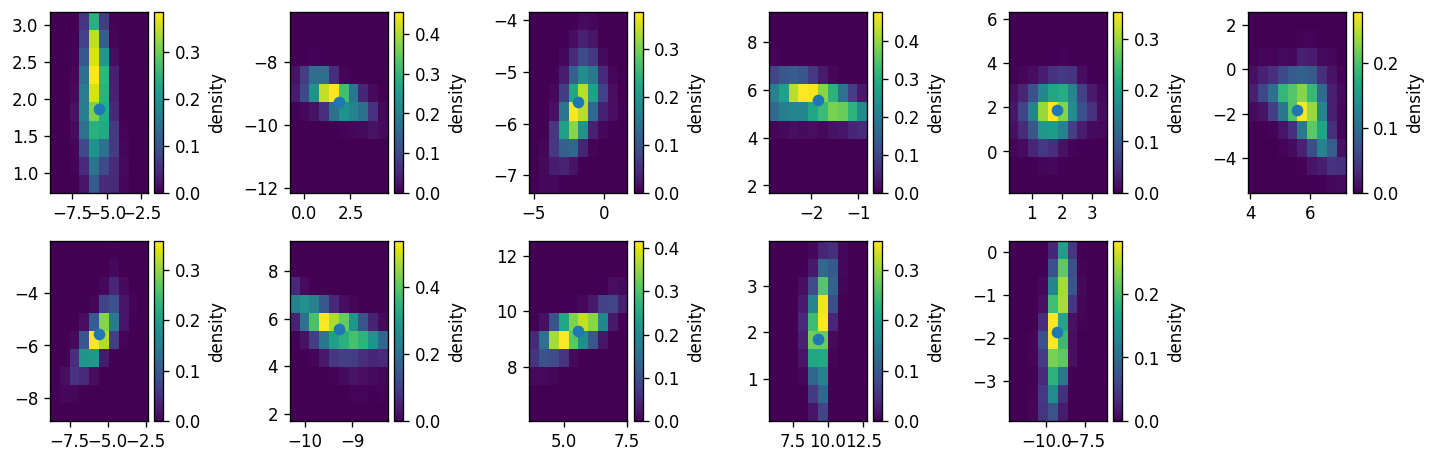

In [64]:
from matplotlib import colors
test_pdfs = pdfs[test_mask]
flow_hists, _ = sample.hist2d_from_flows_with_error([flow], test_x_bins, test_y_bins, feature_scaler, context_scaler=context_scaler, context=test, num_samples=10000, density=True)
def hist_plot_flow(ax, stuff, i):
    hist, *bins = stuff
    XX, YY = np.meshgrid(bins[0], bins[1])
    print(np.nanmin(hist), np.nanmax(hist))
    a = ax.pcolormesh(XX, YY, (hist.T),norm=colors.LogNorm(vmin=np.nanmin(hist)+1e-9, vmax=np.nanmax(np.where(hist==np.inf, 0, hist))),
                   cmap='Reds', shading='auto')
    ax.contour(XX, YY, test_pdfs[i], levels=levels, alpha=0.8)
    plt.colorbar(a, ax=ax, label='absolute relative error')

def hist_plot(ax, stuff, i):
    hist, *bins = stuff
    XX, YY = np.meshgrid(bins[0], bins[1])
    a = ax.pcolormesh(XX, YY, (hist.T), shading='flat',cmap='viridis')#, norm=colors.LogNorm())
    plt.colorbar(a, ax=ax, label='density')
    ax.scatter(test[i][0], test[i][1])
autogrid(
    list(zip(flow_hists, test_x_bins, test_y_bins)),
    hist_plot,
);

In [ ]:
def run_pulls(h_obs, h_exp, h_exp_err):
    '''
    Run binned significance following: 
    https://cds.cern.ch/record/2643488

    Parameters
    ----------
    h_obs : list or NumPy array
        Observed bin values (data)
    h_exp : list or NumPy array
        Expected bin values (background)
    h_exp_err : list or NumPy array
        Error on expected (background error)

    '''

    h_pull = np.zeros(len(h_obs))
    for i in range(len(h_obs)):
        nbObs = h_obs[i]
        nbExp = h_exp[i]
        nbExpEr = h_exp_err[i]
        if nbExp == 0 or nbObs == 0:
            continue
        # relabel variables to match CDS formula
        factor1 = nbObs*np.log( (nbObs*(nbExp+nbExpEr**2))/(nbExp**2+nbObs*nbExpEr**2) )
        factor2 = (nbExp**2/nbExpEr**2)*np.log( 1 + (nbExpEr**2*(nbObs-nbExp))/(nbExp*(nbExp+nbExpEr**2)) )
        if nbObs < nbExp:
            pull  = -np.sqrt(2*(factor1 - factor2))
        else:
            pull  = np.sqrt(2*(factor1 - factor2))
        h_pull[i] = pull
    return h_pull